# Homework 6: The Cepheid Period-Luminosity-Metallicity Relation

In [1]:
%matplotlib inline
import numpy as np
from matplotlib.pyplot import *
from matplotlib import rc
import scipy.stats as stats
from IPython.display import display, Markdown, Latex

# Make more readable plots
rc('font',**{'size':14})
rc('xtick',**{'labelsize':16})
rc('ytick',**{'labelsize':16})
rc('axes',**{'labelsize':18,'titlesize':18})

Load in the data file here. The values are:

+ P = Period (days)
+ D = Distance (kpc)
+ V = $V$ band (mag)
+ J = $J$ band (mag)
+ H = $H$ band (mag)
+ K = $K$ band (mag)
+ E = Color excess/reddening, $E_{B-V}$ (mag)
+ Z = Metallicity ([Fe/H])

In [2]:
P, D, V, J, H, K, E, Z = np.loadtxt("cepheid_data.txt", unpack=True, usecols=range(1, 9), delimiter=',')
logP = np.log10(P)

Recall that the model we are trying to fit to the data is of the form

$$M_\lambda = \alpha + \beta \log P + \gamma\mathrm{[Fe/H]}$$

where $M_\lambda$ is the absolute magnitude at a given wavelength $\lambda$.

Our first task is to color correct the data for input into the least squares algorithm. As noted in the prompt, the _reddening_ is $E_{B-V} = A_B - A_V$, with $A_\lambda$ being the extinction at a wavelength $\lambda$ in magnitudes. Via Draine (2011), we given that the average value of $R_V = A_V / E_{B-V} \approx 3.1$ in the Milky Way. Therefore, we just have that $A_V \approx 3.1 E_{B-V}$ and we can solve for the $V$-band extinction. Since we also know the relation between the different extinction values, given as $A_\lambda/A_V$, then we can indeed solve for all four values of $A_\lambda$.

In [3]:
A_V = 3.1*E
A_J = 0.271*A_V
A_H = 0.175*A_V
A_K = 0.117*A_V

Let's apply the distance modulus here to get the absolute magnitudes in each band.

In [4]:
M_V = V - 5*np.log10(D*1000) + 5 - A_V
M_J = J - 5*np.log10(D*1000) + 5 - A_J
M_H = H - 5*np.log10(D*1000) + 5 - A_H
M_K = K - 5*np.log10(D*1000) + 5 - A_K
bands = ["V", "J", "H", "K"]
Ms = [M_V, M_J, M_H, M_K]

-----

## Q1: 

Using linear least squares, estimate the parameters in the boxed equation above, $\alpha$, $\beta$, and $\gamma$, and their uncertainties. You can pick your favorite photometric band.

The design matrix will have the form
$$\mathbf{X} = \begin{pmatrix}
1 & \log P_0 & Z_0 \\
1 & \log P_1 & Z_1 \\
 & \vdots & \\
1 & \log P_n & Z_n \\
\end{pmatrix}$$
while the parameter vector is 
$$\boldsymbol{\theta} = \begin{pmatrix}
\alpha \\ \beta \\ \gamma
\end{pmatrix}$$

The code below will also produce a design matrix without the column of metallicities, for the bonus problem.

In [5]:
def get_design_matrix(metallicity=True):
    if metallicity:
        X = np.zeros((len(logP), 3)) # An Nx3 matrix
        X[:, 0] = 1
        X[:, 1] = logP
        X[:, 2] = Z
    else:
        X = np.zeros((len(logP), 2)) # An Nx2 matrix
        X[:, 0] = 1
        X[:, 1] = logP
    return np.matrix(X)

The general form of the parameter estimates from least squares is given by 

$$ \boldsymbol{\hat{\theta}} = (\mathbf{X}^\dagger \mathbf{V}^{-1}\mathbf{X})^{-1}\mathbf{X}^\dagger\mathbf{V}^{-1}\mathbf{y} $$

and the covariance matrix of the parameters is

$$ \mathbf{P} =(\mathbf{X}^\dagger \mathbf{V}^{-1}\mathbf{X})^{-1}$$

The two functions below can take a covariance matrix $\mathbf{V}$ but do not need to. In the errorless case, then the $\mathbf{V}$ goes away, and then $\boldsymbol{\hat{\theta}} \to \boldsymbol{\theta}$.

In [6]:
def leastsq(X, y, V=None):
    """
    X = design matrix
    y = data vector
    V = covariance matrix
    
    Return: theta, parameter estimates
    """
    XT = X.T
    yvec = np.matrix(y).T
    if V is None:
        return np.linalg.inv(XT*X)*XT*yvec
    else:
        Vinv = np.linalg.inv(V)
        return np.linalg.inv(XT*Vinv*X)*XT*Vinv*yvec
def param_cov(X, V=None):
    """
    X = design matrix
    V = covariance matrix
    
    Return: 
    """
    if V is None:
        return np.sqrt(np.diagonal(np.linalg.inv(X.T*X)))
    else:
        return np.sqrt(np.diagonal(np.linalg.inv(X.T*np.linalg.inv(V)*X)))

For each of our bands, we will solve for the best parameters

In [7]:
X = get_design_matrix()
params = np.zeros((4, 3))
for i, M in enumerate(Ms):
    band = bands[i]
    p = leastsq(X, M)
    # below is a set of functions specifically for Jupyter notebooks
    display(Markdown(r'$%s$-band parameters: $\hat{\alpha} = %0.3f, \hat{\beta} = %0.3f, \
                     \hat{\gamma} = %0.3f$'%(band, p[0], p[1], p[2])))
    params[i, :] = np.transpose(p)

$V$-band parameters: $\hat{\alpha} = -2.160, \hat{\beta} = -2.127, \
                     \hat{\gamma} = -0.094$

$J$-band parameters: $\hat{\alpha} = -3.018, \hat{\beta} = -2.638, \
                     \hat{\gamma} = -0.077$

$H$-band parameters: $\hat{\alpha} = -3.203, \hat{\beta} = -2.800, \
                     \hat{\gamma} = -0.017$

$K$-band parameters: $\hat{\alpha} = -3.266, \hat{\beta} = -2.834, \
                     \hat{\gamma} = -0.060$

Remember, because there are no errors, there are no errors on the parameters! However, below is the set of parameter errors if you run through and assume $\mathbf{V} = \mathbf{I}$. Note that regardless of which magnitude band you use, that does not factor in and you will always get the same values.

-----

## Q2: 

Please plot your fit against the data. You can do this in a number of ways, I leave that to you as long as you can demonstrate that the fit is good (this is also a good check for you!).


Plot the best-fit model for $V$ band as a function of $\log P$, ignoring the metallicity.

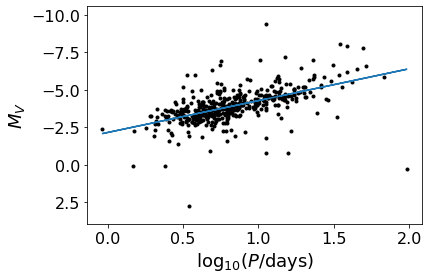

In [8]:
alpha, beta, gamma = params[0, :] #get V-band bet parameters
plot(logP, M_V, 'k.')
plot(logP, alpha + beta*logP) #ignore metallicity
dm = np.ptp(M_V) #maximum extent of magnitudes
ylim(np.max(M_V)+0.1*dm, np.min(M_V)-0.1*dm)
xlabel(r'$\log_{10} (P / {\rm days})$')
ylabel(r"$M_V$")
show()

We can also plot the residuals, this time we will include metallicity

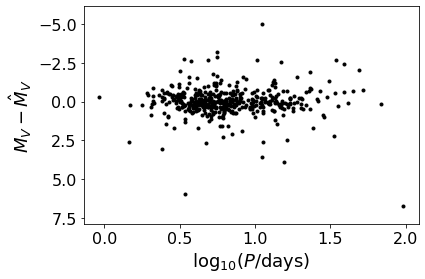

In [9]:
model = alpha + beta*logP + gamma*Z
residuals = M_V - model
plot(logP, residuals, 'k.')
dm = np.ptp(residuals) #maximum extent of magnitudes
ylim(np.max(residuals)+0.1*dm, np.min(residuals)-0.1*dm)
xlabel(r'$\log_{10} (P / {\rm days})$')
ylabel(r"$M_V - \hat{M}_V$")
show()

Or, to perhaps visualize it easier and spread the points out, versus just the observation number

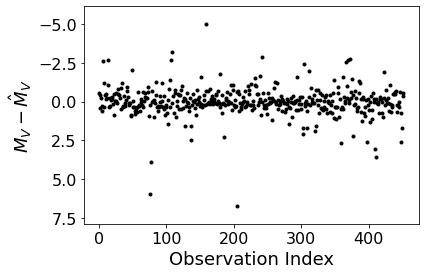

In [10]:
plot(residuals, 'k.')
dm = np.ptp(residuals) #maximum extent of magnitudes
ylim(np.max(residuals)+0.1*dm, np.min(residuals)-0.1*dm)
xlabel(r'Observation Index')
ylabel(r"$M_V - \hat{M}_V$")
show()

-----

## Q3: 

Assume that the errors on the apparent magnitudes are all $\sigma_m$ = 0.1 mag. Repeat the estimate of the parameters and their uncertainties.

In [11]:
V = np.matrix(np.identity(len(logP)) * 0.1)

In [12]:
X = get_design_matrix()
params = np.zeros((4, 3))
for i, M in enumerate(Ms):
    band = bands[i]
    p = leastsq(X, M, V=V)
    # below is a set of functions specifically for Jupyter notebooks
    display(Markdown(r'$%s$-band parameters: $\hat{\alpha} = %0.3f, \hat{\beta} = %0.3f, \
                     \hat{\gamma} = %0.3f$'%(band, p[0], p[1], p[2])))
    params[i, :] = np.transpose(p)

$V$-band parameters: $\hat{\alpha} = -2.160, \hat{\beta} = -2.127, \
                     \hat{\gamma} = -0.094$

$J$-band parameters: $\hat{\alpha} = -3.018, \hat{\beta} = -2.638, \
                     \hat{\gamma} = -0.077$

$H$-band parameters: $\hat{\alpha} = -3.203, \hat{\beta} = -2.800, \
                     \hat{\gamma} = -0.017$

$K$-band parameters: $\hat{\alpha} = -3.266, \hat{\beta} = -2.834, \
                     \hat{\gamma} = -0.060$

As you can see, the parameter estimates are identical to the ones before. However, this time we have uncertainties on our estimates. Since for each case we are assuming that the errors are the same on all of the observations, then the errors on the parameters are all going to be the same.

In [13]:
cov = param_cov(X)
display(Markdown(r'$\sigma_{\alpha} = %0.3f, \sigma_{\beta} = %0.3f, \
                \sigma_{\gamma} = %0.3f$'%(cov[0], cov[1], cov[2])))

$\sigma_{\alpha} = 0.143, \sigma_{\beta} = 0.168, \
                \sigma_{\gamma} = 0.252$

-----

## Bonus: 

Again assume that the errors on the apparent magnitudes are all $\sigma_m$ = 0.1 mag. Repeat your least squares estimate and perform it again when you fit a nested model of the form $M = \alpha + \beta \log P$.

In [14]:
X_nested = get_design_matrix(metallicity=False)
params_nested = np.zeros((4, 2))
for i, M in enumerate(Ms):
    band = bands[i]
    p = leastsq(X_nested, M)
    display(Markdown(r'$%s$-band parameters: $\hat{\alpha} = %0.3f, \hat{\beta} = %0.3f$'%(band, p[0], p[1])))
    params_nested[i, :] = np.transpose(p)

$V$-band parameters: $\hat{\alpha} = -2.147, \hat{\beta} = -2.147$

$J$-band parameters: $\hat{\alpha} = -3.007, \hat{\beta} = -2.654$

$H$-band parameters: $\hat{\alpha} = -3.201, \hat{\beta} = -2.804$

$K$-band parameters: $\hat{\alpha} = -3.258, \hat{\beta} = -2.847$

Let's replot the residuals again just to verify:

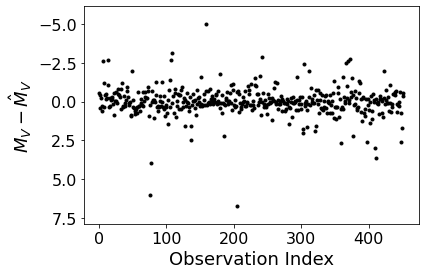

In [15]:
nested_model = params_nested[0, 0] + params_nested[0, 1]*logP
nested_residuals = M_V - nested_model
plot(nested_residuals, 'k.')
dm = np.ptp(nested_residuals) #maximum extent of magnitudes
ylim(np.max(nested_residuals)+0.1*dm, np.min(nested_residuals)-0.1*dm)
xlabel(r'Observation Index')
ylabel(r"$M_V - \hat{M}_V$")
show()

There's not really an obviously significant change here.

Below I will calculate the $F$ statistic:

$$
F \equiv \frac{\displaystyle{\left(\frac{\chi_{\rm nested}^2 - \chi_{\rm full}^2}{\nu_{\rm nested} - \nu_{\rm full}}\right)}}{\displaystyle{\left(\frac{\chi_{\rm full}^2}{\nu_{\rm full}}\right)}},
$$
where $\chi^2$ is the chi-squared value for each model, $\nu$ is the number of degress of freedom. Note that in the original homework prompt and the notes, I swapped the order of the denominator of the numerator, writing $\nu_{\rm full} - \nu_{\rm nested}$. I had confused myself with the number of degrees of freedom and the number of parameters.

In [16]:
N = len(residuals)
chisq_full = np.sum(residuals**2)
chisq_nested = np.sum(nested_residuals**2)
dof_full = N - 3
dof_nested = N - 2

In [17]:
F = ((chisq_nested - chisq_full)/(dof_nested - dof_full)) / (chisq_full / dof_full)
print(F)

0.15027102472157278


In [18]:
p_value = 1 - stats.f.cdf(F, dof_nested - dof_full, dof_full)
print("P-value: %0.3f"%p_value)

P-value: 0.698


In the language of p-values, lower p-values indicate more significance. That is, when we talk about the magical threshold of $p = 0.05$, we are saying that there is only a 5% chance that what we are seeing comes from a random fluctuation. In this case, the outcome is pretty probable under the null hypothesis. If instead $F$ was much higher, then we are much higher up on the tail of the $F$-distribution, and so the chance of getting that under the null hypothesis is extremely small.

In [19]:
p_value = 1 - stats.f.cdf(30, dof_nested - dof_full, dof_full)
print("P-value: %0.3e"%p_value)

P-value: 7.207e-08
